In [1]:
import torch
import torchtext
import random
from torchtext.datasets import IMDB
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import vocab
from collections import Counter, OrderedDict
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

In [17]:
hyper_parameter={
    'batch_size' : 16, #5,16,32,64,128
    'learning_rate' : 1e-3, #1e-1,1e-3,1e-5,1e-7,1e-9
    'N_EPOCHS' : 5,
}

In [3]:
train_iter = IMDB(split='train')
tokenizer = get_tokenizer('spacy', language='en_core_web_sm')

def yield_tokens_batch(train_iter):
    for (label, line) in train_iter:
      yield tokenizer(line)
voc = build_vocab_from_iterator(yield_tokens_batch(train_iter), min_freq =3, specials=["<PAD>","<unk>"])
voc.set_default_index(voc['<unk>'])
# label_transform = lambda x: 1 if x == 'pos' else 0
label_transform = lambda x: 1 if x == 2 else 0
text_transform = lambda x: [voc[token] for token in tokenizer(x)]

/home/cliu282/miniconda3/lib/python3.11/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [4]:
import numpy as np
train_iter = IMDB(split='train')
test_iter = IMDB(split='test')
train_list = list(train_iter)
random.shuffle(train_list)

dev_list = train_list[:7500]
devfile = open("dev.txt", "w")
for element in dev_list:
    devfile.write(str(element[1]) + str(element[0])+"\n")
devfile.close()

test_list = list(test_iter)
testfile = open("test.txt", "w")
for element in test_list:
    testfile.write(str(element[1])+ str(element[0]) + "\n")
testfile.close()

train_list = train_list[7500:]

In [5]:
def collate_batch(batch):
   label_list, text_list = [], []
    # change this thing to be the size per batch
   max_len = 50
   for (_label, _text) in batch:
        label_list.append(label_transform(_label))
        processed_text = torch.LongTensor(text_transform(_text))
        # processed_text = nn.ConstantPad1d((0, max_len - processed_text.shape[0]), 0)(processed_text)
        text_list.append(processed_text)

    # change the padding value (e.g., 0)
   return   pad_sequence(text_list, padding_value=0),torch.LongTensor(label_list)

In [19]:
#5,16,32,64,128
batch_size = hyper_parameter['batch_size']

train_iterator = DataLoader(train_list, batch_size, shuffle=True,
                              collate_fn=collate_batch, drop_last=True)
valid_iterator = DataLoader(dev_list, batch_size, shuffle=False,
                              collate_fn=collate_batch, drop_last=True)
test_iterator = DataLoader(test_list, batch_size, shuffle=False,
                              collate_fn=collate_batch, drop_last=True)
print(f'Number of training examples: {len(train_iterator)}')
print(f'Number of dev examples: {len(valid_iterator)}')
print(f'Number of test examples: {len(test_iterator)}')

Number of training examples: 1093
Number of dev examples: 468
Number of test examples: 1562


In [7]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")
device

device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
device

GPU is available


device(type='cuda', index=3)

In [8]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [9]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division
    acc = correct.sum() / len(correct)
    return acc

In [10]:
from tqdm import tqdm
def train(model, iterator, optimizer, criterion):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for inputs, labels in tqdm(iterator):

        optimizer.zero_grad()

        predictions = model(inputs.to(device)).squeeze(1).to(device)
        # predictions = model(inputs.to(device)).to(device)

        loss = criterion(predictions,labels.float().to(device)).to(device)

        acc = binary_accuracy(predictions, labels.float().to(device))

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):

    epoch_loss = 0
    epoch_acc = 0
    all_prediction = []
    all_labels = []

    model.eval()

    with torch.no_grad():
        for  inputs, labels in iterator:

            predictions = model(inputs.to(device)).squeeze(1).to(device)
            # predictions = model(inputs.to(device)).to(device)

            loss = criterion(predictions,labels.float().to(device)).to(device)

            acc = binary_accuracy(predictions, labels.float().to(device))

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            # predictions = predictions.round().cpu().numpy()
            rounded_preds = torch.round(torch.sigmoid(predictions)).cpu().numpy().astype(int)
            all_prediction.extend(rounded_preds)
            all_labels.extend(labels.cpu().numpy())

    return epoch_loss / len(iterator), epoch_acc / len(iterator), all_prediction, all_labels

In [11]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs, elapsed_time

In [12]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch import sum as tensor_sum
# class LSTM(nn.Module):
#     def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, padding_idx):
#         super().__init__()
#         self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx=padding_idx)
        
#         # Define LSTM layer
#         self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        
#         # Define a fully connected layer that maps from hidden state space to output space
#         self.fc = nn.Linear(hidden_dim, output_dim)

#     def forward(self, text):
#         # text: [seq_len, batch_size]
        
#         embedded = self.embedding(text)  # embedded: [seq_len, batch_size, embedding_dim]

#         # LSTM output: output, (hidden state, cell state)
#         output, (hidden, cell) = self.lstm(embedded)  # hidden: [1, batch_size, hidden_dim]

#         # Use the last hidden state for the fully connected layer
#         hidden = hidden.squeeze(0)  # hidden: [batch_size, hidden_dim]

#         return self.fc(hidden)

# LSTM implementation
class LSTM(nn.Module):

    def __init__(self, input_dim, pad_index, embedding_dim, batch_size, hidden_size=100, bidirectional=False, num_layers=2, dropout_p=0.1, pre_trained_embeddings=None, tunable_pre_trained_embedding=False):
        super(LSTM, self).__init__()

        self.pad_index = pad_index

        self.bidirectional = bidirectional
        self.num_directions = 1 if not self.bidirectional else 2
        self.hidden_size = hidden_size
        self.dropout_p = dropout_p
        self.num_layers = num_layers
        self.embedding_dim = embedding_dim
        self.batch_size = batch_size
        self.input_dim=input_dim
        self.pre_trained_embeddings = pre_trained_embeddings
        self.tunable_pre_trained_embedding = tunable_pre_trained_embedding if self.pre_trained_embeddings is not None else False
        # add learnable embedding + frozen embedding or just frozen embedding
        self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx=pad_index)
        self.dropout = nn.Dropout(dropout_p)
        embeddingSize = 2 if self.pre_trained_embeddings is not None and self.tunable_pre_trained_embedding else 1
        self.lstm = nn.LSTM(
            bidirectional=bidirectional,
            input_size=embedding_dim,  # Adjust according to your embedding setup
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout_p if num_layers > 1 else 0,
            
        )
        self.fc1 = nn.Linear(self.hidden_size*self.num_directions, self.embedding_dim, bias=False)
        self.fc2 = nn.Linear(self.embedding_dim, self.input_dim, bias=False)

    def init_hidden(self, batch_size):
        # Initialize hidden and cell states with zeros
        h_0 = torch.zeros(self.num_layers * self.num_directions, batch_size, self.hidden_size).to(device)
        c_0 = torch.zeros(self.num_layers * self.num_directions, batch_size, self.hidden_size).to(device)
        return (h_0, c_0)

    def forward(self, x):
        lengths=x.shape[0]-tensor_sum(x==0,dim=0).squeeze().cpu()
        hidden = self.init_hidden(x.size(0))

        if self.pre_trained_embeddings is not None:
            embed_frozen = self.embedding(x)
            if self.tunable_pre_trained_embedding:
                embed_tunable = self.tunable_embedding(x)
                embed = self.dropout(torch.cat((embed_tunable, embed_frozen), dim=2))
            else:
                embed = self.dropout(embed_frozen)
        else:
            embed = self.dropout(self.embedding(x))
        packed_input = nn.utils.rnn.pack_padded_sequence(embed, lengths, batch_first=False, enforce_sorted=False)
        output, (h_n, c_n) = self.lstm(packed_input, hidden)
        seq_unpacked, _ = nn.utils.rnn.pad_packed_sequence(output, batch_first=True, padding_value=self.pad_index) # pack the outputs to a padded matrix to feed to FFN
        decoded = self.fc1(seq_unpacked)
        decoded = self.dropout(decoded)
        decoded = self.fc2(decoded)
        # logits = F.log_softmax(decoded, dim=-1) # get the highest prob to predict next word
        return decoded
    
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, padding_idx):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text):
        text_lengths=text.shape[0]-tensor_sum(text==0,dim=0).squeeze().cpu()
        # text: [batch_size, seq_len]
        embedded = self.embedding(text)  # embedded: [batch_size, seq_len, embedding_dim]

        # Pack sequence
        packed_embedded = pack_padded_sequence(embedded, text_lengths, batch_first=False, enforce_sorted=False)
        
        # LSTM output
        packed_output, (hidden, cell) = self.lstm(packed_embedded)

        # Unpack sequence
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        # Average pooling
        avg_pool = torch.mean(output, dim=1)

        # Feedforward network
        return self.fc(avg_pool)

In [13]:
INPUT_DIM = voc.__len__()
EMBEDDING_DIM = 300
HIDDEN_DIM = 256
OUTPUT_DIM = 1
PAD_IDX = voc.__getitem__('<PAD>')
print(PAD_IDX)
# model_LSTM = LSTM(INPUT_DIM,EMBEDDING_DIM,HIDDEN_DIM,OUTPUT_DIM,PAD_IDX)
# model_LSTM = LSTM(
#     input_dim=INPUT_DIM,
#     pad_index=PAD_IDX,
#     embedding_dim=EMBEDDING_DIM,
#     batch_size=hyper_parameter['batch_size'],
#     hidden_size=HIDDEN_DIM,
#     bidirectional=True,
#     num_layers=2,
#     dropout_p=0.3,
# )
model_LSTM = LSTMClassifier(INPUT_DIM,EMBEDDING_DIM,HIDDEN_DIM,OUTPUT_DIM,PAD_IDX)
print(f'The LSTM model has {count_parameters(model_LSTM):,} trainable parameters')
# optimizer = optim.SGD(model_LSTM.parameters(), lr=hyper_parameter['learning_rate'])
optimizer = optim.Adam(model_LSTM.parameters(), lr=hyper_parameter['learning_rate'])
criterion_LSTM = nn.BCEWithLogitsLoss()
model_LSTM = model_LSTM.to(device)
criterion_LSTM = criterion_LSTM.to(device)
time_list_LSTM = []
acc_list_LSTM = []
acc_list_lr_LSTM = []

0
The LSTM model has 15,154,949 trainable parameters


In [20]:
torch.cuda.empty_cache()

N_EPOCHS = hyper_parameter['N_EPOCHS']

best_valid_loss = float('inf')

total_time=0
last_val_acc=0
last_val_acc_lr=0
final_valid_prediction=[]
final_labels = []

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss, train_acc = train(model_LSTM, train_iterator, optimizer, criterion_LSTM)
    valid_loss, valid_acc, valid_prediction, all_labels = evaluate(model_LSTM, valid_iterator, criterion_LSTM)

    end_time = time.time()

    epoch_mins, epoch_secs, epoch_total_time = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_LSTM.state_dict(), 'model_LSTM.pt')

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    total_time=total_time+epoch_total_time
    # average_time=total_time/N_EPOCHS
    if epoch == N_EPOCHS - 1:
        last_val_acc=round(valid_acc * 100, 2)
        final_valid_prediction=valid_prediction
        final_labels = all_labels
        
time_tuple=(batch_size,total_time)
acc_tuple=(batch_size,last_val_acc)
acc_tuple_lr=(hyper_parameter['learning_rate'],last_val_acc)
time_list_LSTM.append(time_tuple)
acc_list_LSTM.append(acc_tuple)
acc_list_lr_LSTM.append(acc_tuple_lr)

100%|██████████| 1093/1093 [01:17<00:00, 14.03it/s]


Epoch: 01 | Epoch Time: 1m 27s
	Train Loss: 0.173 | Train Acc: 93.94%
	 Val. Loss: 0.320 |  Val. Acc: 88.47%


100%|██████████| 1093/1093 [01:16<00:00, 14.28it/s]


Epoch: 02 | Epoch Time: 1m 25s
	Train Loss: 0.073 | Train Acc: 97.82%
	 Val. Loss: 0.339 |  Val. Acc: 88.34%


100%|██████████| 1093/1093 [01:14<00:00, 14.70it/s]


Epoch: 03 | Epoch Time: 1m 23s
	Train Loss: 0.037 | Train Acc: 99.15%
	 Val. Loss: 0.533 |  Val. Acc: 87.98%


100%|██████████| 1093/1093 [01:10<00:00, 15.46it/s]


Epoch: 04 | Epoch Time: 1m 20s
	Train Loss: 0.020 | Train Acc: 99.51%
	 Val. Loss: 0.669 |  Val. Acc: 87.71%


100%|██████████| 1093/1093 [01:15<00:00, 14.49it/s]


Epoch: 05 | Epoch Time: 1m 24s
	Train Loss: 0.011 | Train Acc: 99.79%
	 Val. Loss: 0.667 |  Val. Acc: 87.81%


In [21]:
model_LSTM.load_state_dict(torch.load('model_LSTM.pt'))
comment_text_test=[]
for i in test_list:
    comment_text_test.append(i[1])

test_loss, test_acc, test_prediction, test_lables = evaluate(model_LSTM, test_iterator, criterion_LSTM)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.367 | Test Acc: 86.78%


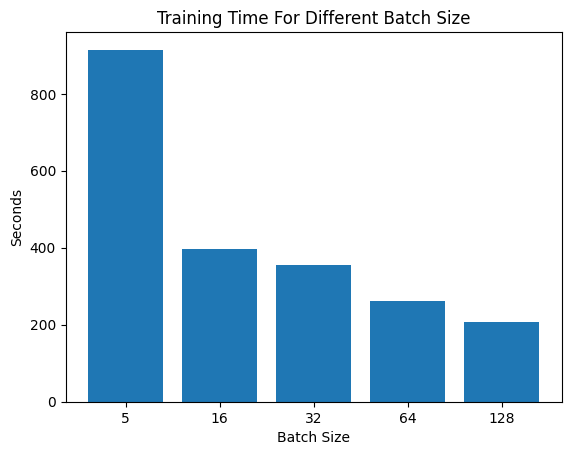

In [ ]:
# plot for compare training time
import matplotlib.pyplot as plt

# acc_list = [(5,10), (16,20), (32,30), (64,40), (128,50)]  
values = [] # List of values
x_labels = [] # Names for each data point
for item in time_list_LSTM:
    x_labels.append(str(item[0]))
    values.append(item[1])

# Creating the bar chart
plt.bar(x_labels, values)

# Adding title and labels
plt.title('Training Time For Different Batch Size')
plt.xlabel('Batch Size')
plt.ylabel('Seconds')

# Show the plot
plt.show()

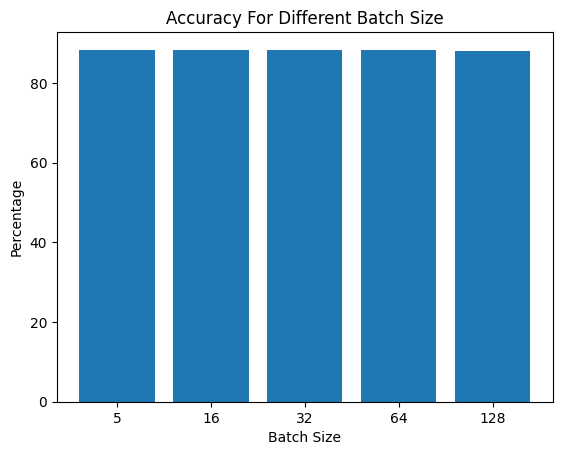

In [ ]:
# plot for compare accuracy
import matplotlib.pyplot as plt

# acc_list = [(5,10), (16,20), (32,30), (64,40), (128,50)]  
values = [] # List of values
x_labels = [] # Names for each data point
for item in acc_list_LSTM:
    x_labels.append(str(item[0]))
    values.append(item[1])

# Creating the bar chart
plt.bar(x_labels, values)

# Adding title and labels
plt.title('Accuracy For Different Batch Size')
plt.xlabel('Batch Size')
plt.ylabel('Percentage')

# Show the plot
plt.show()

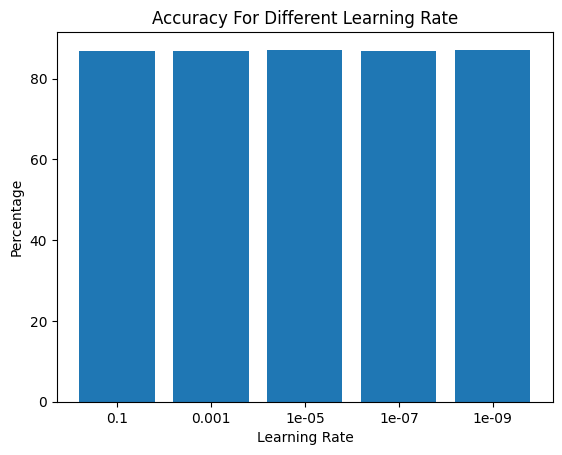

In [ ]:
# plot for compare learning rate
import matplotlib.pyplot as plt

# acc_list = [(5,10), (16,20), (32,30), (64,40), (128,50)]  
values = [] # List of values
x_labels = [] # Names for each data point
for item in acc_list_lr_LSTM:
    x_labels.append(str(item[0]))
    values.append(item[1])

# Creating the bar chart
plt.bar(x_labels, values)

# Adding title and labels
plt.title('Accuracy For Different Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Percentage')

# Show the plot
plt.show()

In [23]:
len(final_valid_prediction)

7488

In [22]:
import csv
import pandas as pd
comment_text_val=[]
for i in dev_list:
    comment_text_val.append(i[1])
df = pd.DataFrame({'Comment':comment_text_val,'Predicted': final_valid_prediction})
df.to_csv('predictions_val_LSTM.csv', index=False)

df = pd.DataFrame({'Comment':comment_text_test,'Predicted': test_prediction})
df.to_csv('predictions_test_LSTM.csv', index=False)

ValueError: All arrays must be of the same length